# 14 图像色彩

## 颜色

### 基色

基色有多种定义, 常用的有:

1. 红绿蓝 (RGB)
2. 红黄蓝
3. 橙色、绿色、紫罗兰
4. 青色、洋红、黄、黑 (CMYK (cyan, magenta, yellow, key))


RGB是加色系统: $(黑 + ) 红 + 蓝 = 洋红$; CMYK 是相反的减色系统: 
$$白 - (白 -  洋红) -(白 -  黄)  = 红$$

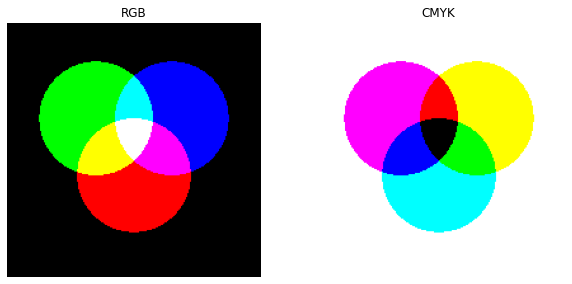

In [133]:
import numpy as np
from matplotlib import pyplot as plt
def draw_circle(img, x, y, r, channel, value, method = 'add'):
    assert method in ('add', 'set')
    coors = np.meshgrid(np.linspace(-1, 1, img.shape[1]), np.linspace(-1, 1, img.shape[0]))
    condition = (coors[0] - x)**2 + (coors[1] - y)**2 < r ** 2
    if   method == 'add': img[condition, channel] += value 
    elif method == 'set': img[condition, channel] = value
    return img

img_rgb = np.zeros((200, 200, 3), dtype = 'uint8')
draw_circle(img_rgb, 0, .2, .45,      channel = 0, value = 255)
draw_circle(img_rgb, -0.3, -.25, .45, channel = 1, value = 255)
draw_circle(img_rgb, +0.3, -.25, .45, channel = 2, value = 255)

img_cmyk = np.full((200, 200, 3), 255, dtype = 'int32')
draw_circle(img_cmyk, 0, .2, .45,      channel = 0, value = -255)
draw_circle(img_cmyk, -0.3, -.25, .45, channel = 1, value = -255)
draw_circle(img_cmyk, +0.3, -.25, .45, channel = 2, value = -255)

plt.figure(figsize = (10, 5))
for i, image, title in zip((1, 2), (img_rgb, img_cmyk), ('RGB', 'CMYK')):
    plt.subplot(1, 2, i)
    plt.imshow(image.astype('uint8'))
    plt.title(title)
    plt.axis('off')
plt.show()

### 光谱

可见光约为 $400\sim 760{\rm \ nm}$ 波长对应的光. 由紫色到红色. 光谱可先对应到 CIE-XYZ 颜色空间中, 再转换为 RGB 值.

#### 参考文献

[1] https://3dz2.com/minerals/spectrum2color/ 

[2] https://www.fourmilab.ch/documents/specrend/  

[3] https://jila.colorado.edu/~ajsh/colour/rainbow.html

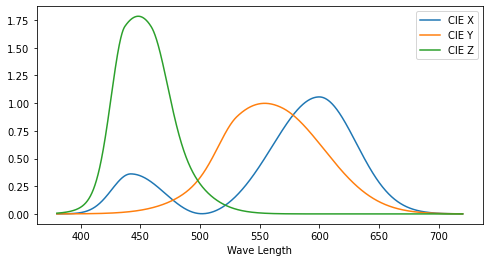

In [83]:
import numpy as np
def wave2cie(wave):
    def xFit_1931(wave):
        t1 = (wave-442.0) * np.where(wave<442.0, 0.0624, 0.0374)
        t2 = (wave-599.8) * np.where(wave<599.8, 0.0264, 0.0323)
        t3 = (wave-501.1) * np.where(wave<501.1, 0.0490, 0.0382)
        return 0.362*np.exp(-0.5*t1*t1) + 1.056*np.exp(-0.5*t2*t2) - 0.065*np.exp(-0.5*t3*t3)
    def yFit_1931(wave):
        t1 = (wave-568.8) * np.where(wave<568.8, 0.0213, 0.0247)
        t2 = (wave-530.9) * np.where(wave<530.9, 0.0613, 0.0322)
        return 0.821*np.exp(-0.5*t1*t1) + 0.286*np.exp(-0.5*t2*t2)
    def zFit_1931(wave):
        t1 = (wave-437.0) * np.where(wave<437.0, 0.0845, 0.0278)
        t2 = (wave-459.0) * np.where(wave<459.0, 0.0385, 0.0725)
        return 1.217*np.exp(-0.5*t1*t1) + 0.681*np.exp(-0.5*t2*t2)
    return np.vstack([f(wave) for f in (xFit_1931, yFit_1931, zFit_1931)]).T

from matplotlib import pyplot as plt
wave = np.linspace(380, 720, 3000)
wave_cie = wave2cie(wave)

plt.figure(figsize = (8, 4))
[plt.plot(wave, wave_cie)]
plt.legend(['CIE %c'%c for c in 'XYZ'])
plt.xlabel('Wave Length')
plt.show()

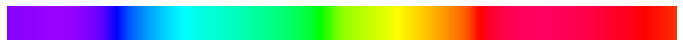

In [128]:
def cie2rgb(xyz):
    rgb = np.linalg.inv(np.array(((.64, .30, .15),
                                  (.33, .60, .06),
                                  (.03, .10, .79)))) @ xyz.T

    # gamma correction
    rgb = np.where(rgb < .018, 4.5 * rgb, 1.099 * (np.clip(rgb, .01, None) ** .45) - .099)
    rgb -= np.clip(np.min(rgb, axis = 0), None, 0)
    rgb /= np.max(rgb, axis = 0)
    return rgb.T

wave = np.linspace(420, 690, 1000)
wave_cie = wave2cie(wave)
wave_rgb = np.transpose(np.tile(
    cie2rgb(wave_cie).reshape((-1, 1, 3))
                        , (1, 50, 1)), (1,0,2))

plt.figure(figsize = (12, 5))
plt.imshow(wave_rgb)
plt.axis('off')
plt.show()

### HSL 颜色空间

除 RGB 以外, 可以用 HSL 表示颜色, 常见于画图程序的取色器中. 其中 $H\in[0^\circ, 360^\circ]$ 为色相 (hue), $S\in[0,1]$ 为饱和度 (saturation), $L\in [0,1]$ 为亮度 (lightness). 转换公式见 [1](https://www.rapidtables.com/convert/color/hsl-to-rgb.html).

亮度为 $0$ 是黑色; 亮度为 $1$ 是白色; 红绿蓝的色相为 $0^\circ,\ 120^\circ, \ 240^\circ$, 且饱和度为 $1$, 亮度 $0.5$. 

黄色、蓝绿、洋红 (yellow, cyan, magenta) 的色相为 $60^\circ,\ 180^\circ, \ 300^\circ$, 且饱和度为 $1$, 亮度 $0.5$.


<br>

有时候图像处理可以转换到 HSL 空间处理.

#### 色环

将色相 $0^\circ\sim 360^\circ$ 的颜色画成一个圈就是色环 (color circle).

#### 参考文献

[1] https://www.rapidtables.com/convert/color/hsl-to-rgb.html

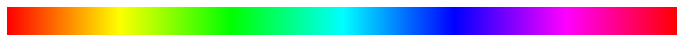

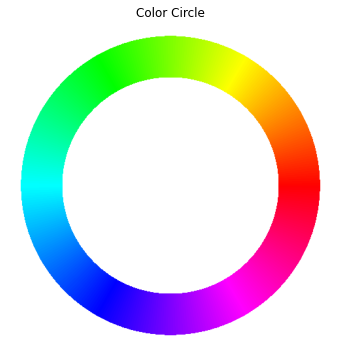

In [127]:
import numpy as np
def hsl2rgb(hsl):
    """Input HSL array with shape (N,3), return RGB values with shape (N,3).
    0 <= H < 360, 0 <= S <= 1, 0 <= L <= 1"""
    h, s, l = hsl[:,0], hsl[:,1], hsl[:,2]
    c = (1 - np.abs(2 * l - 1)) * s
    x = c * (1 - np.abs((h / 60) % 2 - 1))
    m = l - c / 2
    rgb = np.zeros_like(hsl)
    rgb[:,0] = np.where((120 <= h) & (h < 240), 0,
               np.where((60 <= h) & (h < 300), x, c))
    rgb[:,1] = np.where((60 <= h) & (h < 180), c,
               np.where(h < 240, x, 0))
    rgb[:,2] = np.where(h < 120, 0,
               np.where((180 <= h) & (h < 300), c, x))
    rgb += m.reshape((-1, 1))
    return np.clip(rgb, 0, 1)

color = np.zeros((360, 3))
color[:,0] = np.linspace(0, 359, num = 360) # hue
color[:,1] = 1. # saturation
color[:,2] = .5 # lightness
rgb = np.transpose(np.tile(
    hsl2rgb(color).reshape((-1, 1, 3))
                        , (1, 15, 1)), (1,0,2))

plt.figure(figsize = (12, 5))
plt.imshow(rgb)
plt.axis('off')
plt.show()

N = 500
coors = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
img = np.where(np.tile((np.abs(coors[0]**2 + coors[1]**2 - .64) < .2).reshape((N,N,-1)), (1,1,3)),
                rgb[0, ((np.arctan2(coors[1], coors[0])/np.pi * 180).astype('int32') + 180)], 1)

plt.figure(figsize = (6, 6))
plt.imshow(img[:,::-1,:])
plt.title('Color Circle')
plt.axis('off')
plt.show()

### 灰度

灰度转换彩色: 可以将 $[0,1]$ 的灰度值对应到色带上 (如前文的光谱), 形成彩色.

彩色转灰度: 灰度值等于 $(R+G+B)/3$.

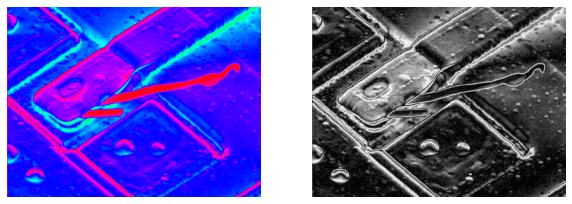

In [175]:
import os
from matplotlib import pyplot as plt
from PIL import Image

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\gadget.png')).convert('L'))

cmap = rgb[0, 120:]
img_colored = cmap[(img / 255. * (cmap.shape[0] - 1)).astype('int32')]
img_gray = img_colored.mean(axis = -1)

plt.figure(figsize = (10, 4))
for i, image in zip((1, 2), (img_colored, img_gray)):
    plt.subplot(1, 2, i)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
plt.show()

### 反色

对于 RGB 图像, 反色 / 补色 (complement) 是将每个数字用 255 减掉: $(r,g,b) \ \rightarrow \ (255-r, \ 255-g,\ 255-b)$

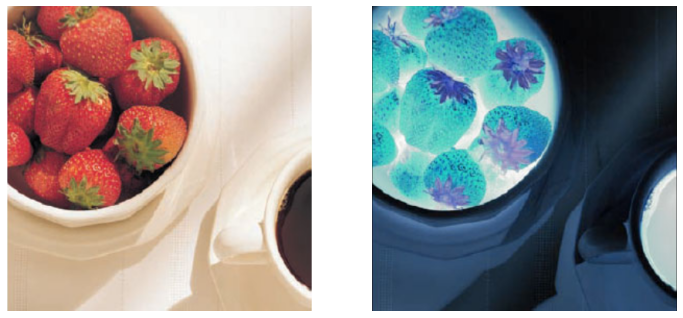

In [14]:
import os
from matplotlib import pyplot as plt
from PIL import Image 
import numpy as np 

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\strawberry.png')))
img_inv = 255 - img

plt.figure(figsize = (12, 6))
for i, image in zip((1,2), (img, img_inv)):
    plt.subplot(1, 2, i)
    plt.imshow(image)
    plt.axis('off')
plt.show()